<a href="https://colab.research.google.com/github/falseywinchnet/Cleanup/blob/main/Recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import IPython
from scipy.io import wavfile
import soundfile as sf
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import numba
import numpy
import io
%matplotlib inline


url = "https://github.com/falseywinchnet/PyITD/raw/main/Dave%20and%20Simon%2C%203.79%20MHz%2C%20LSB.wav"
#this is an noisy shortwave conversation I got from a friend. I use it to test denoising methods.
#it is reasonably normalized and features a good noise diversity.
response = urllib.request.urlopen(url)
data, rate = sf.read(io.BytesIO(response.read()))
data = data

In [ ]:
from __future__ import division
'''
Copyright 2023 Joshuah Rainstar
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY,
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
'''
'''
Copyright 2023 Joshuah Rainstar
This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
'''


import numba
import numpy
import numpy as np

from numpy.fft import irfft, rfft


@numba.njit(numba.float64(numba.float64[:]))
def man(arr):
    med = numpy.nanmedian(arr[numpy.nonzero(arr)])
    return numpy.nanmedian(numpy.abs(arr - med))

@numba.njit(numba.float64(numba.float64[:]))
def atd(arr):
    x = numpy.square(numpy.abs(arr - man(arr)))
    return numpy.sqrt(numpy.nanmean(x))

@numba.njit(numba.float64(numba.float64[:]))
def threshold(data: numpy.ndarray):
 a = numpy.sqrt(numpy.nanmean(numpy.square(numpy.abs(data -numpy.nanmedian(numpy.abs(data - numpy.nanmedian(data[numpy.nonzero(data)]))))))) + numpy.nanmedian(data[numpy.nonzero(data)])
 return a

def generate_true_logistic(points):
    if points ==1:
      return 1
    if points ==2:
      return numpy.asarray([0.5,0.5])
    if points ==3:
      return numpy.asarray([0.2,0.6,0.2])

    fprint = numpy.linspace(0.0,1.0,points)
    fprint[1:-1]  /= 1 - fprint[1:-1]
    fprint[1:-1]  = numpy.log(fprint[1:-1])
    fprint[-1] = ((2*fprint[-2])  - fprint[-3])
    fprint[0] = -fprint[-1]
    return numpy.interp(fprint, (fprint[0], fprint[-1]),  (0, 1))


def generate_logit_window(size,sym =True):
  if size % 2:
    e = generate_true_logistic((size+1)//2)
    result = numpy.zeros(size)
    result[0:(size+1)//2] = e
    result[(size+1)//2:] = e[0:-1][::-1]
    return result
  else:
    e = generate_true_logistic(size//2)
    e = numpy.hstack((e,e[::-1]))
    return e


def generate_hann(M, sym=True):
    a = [0.5, 0.5]
    fac = numpy.linspace(-numpy.pi, numpy.pi, M)
    w = numpy.zeros(M)
    for k in range(len(a)):
        w += a[k] * numpy.cos(k * fac)
    return w

def generate_sawtooth_filter(size):
  if size ==1:
      return 1
  if size ==2:
      return numpy.asarray([0.5,0.5])
  if size ==3:
      return numpy.asarray([0.2,0.6,0.2])

  fprint = numpy.linspace(0.0,1.0,size)
  if size % 2:
    e = numpy.linspace(0.0,1.0,(size+1)//2)
    result = numpy.zeros(size)
    result[0:(size+1)//2] = e
    result[(size+1)//2:] = e[0:-1][::-1]
    return result
  else:
    e = numpy.linspace(0.0,1.0,(size+1)//2)
    e = numpy.hstack((e,e[::-1]))
    return e

@numba.jit(numba.float64(numba.float64[:],numba.float64[:]))
def innerprod(a, b):
        acc = 0
        for i in range(len(a)):
            acc = acc + a[i] * b[i]
        return acc

#adapted from https://github.com/stuartarchibald
#note: the first array must be larger than the second or this code will crash.
#this function also only accepts double input
@numba.jit(numba.float64[:](numba.float64[:],numba.float64[:]))
def same_convolution_float_1d(ap1, ap2):
        n1= len(ap1)
        n2= len(ap2)

        n_left = n2 // 2
        n_right = n2 - n_left - 1

        ret = numpy.zeros(n1, numpy.float64)

        idx = 0
        inc = 1

        for i in range(n2 - n_left, n2):
            ret[idx] = innerprod(ap1[:i], ap2[-i:])
            idx += inc

        for i in range(n1 - n2 + 1):
            ret[idx] = innerprod(ap1[i : i + n2], ap2)
            idx += inc

        for i in range(n2 - 1, n2 - 1 - n_right, -1):
            ret[idx] = innerprod(ap1[-i:], ap2[:i])
            idx += inc
        return ret

@numba.jit(numba.float64[:](numba.float64[:],numba.int64))
def float_zero_pad_1d(array, pad_width):

    padded = numpy.zeros(array.size+pad_width*2, dtype=numpy.float64)
    # Copy old array into correct space
    padded[pad_width:-pad_width] = array[:]

    return padded

@numba.jit(numba.float64[:,:](numba.float64[:,:],numba.int64,numba.int64))
def float_zero_pad_2d(array, E,N):
    X = E * 2
    Y = N * 2
    padded = numpy.zeros(((array.shape[0]+X,array.shape[1]+Y)), dtype=numpy.float64)
    # Copy old array into correct space
    padded[E:-E,N:-N] = array[:]

    return padded


@numba.jit(numba.float64[:](numba.float64[:],numba.int64))
def moving_average(x, w):
    return same_convolution_float_1d(x, numpy.ones(w,numpy.float64)) / w

@numba.jit(numba.float64[:](numba.float64[:],numba.int64))
def smoothpadded(data: numpy.ndarray,n:int):
  return moving_average(float_zero_pad_1d(data, n*2),n)[n*2: -n*2]




@numba.jit(numba.float64[:,:](numba.float64[:,:]))
def sawtooth_filter(data):
    E= 30
    filter = numpy.asarray([0.,0.14285714,0.28571429,0.42857143,0.57142857,0.71428571,0.85714286,1.,0.85714286,0.71428571,0.57142857,0.42857143,0.28571429,0.14285714,0.])
    working = float_zero_pad_2d(data,E,E)
    working2 = numpy.ravel(working) #ravel provides a view
    working2[:] = same_convolution_float_1d(working2, filter[:])
    working[:] = working2.reshape(working.shape)
    working = working/7
    return  working[E:-E:,E:-E:]

@numba.jit(numba.float64[:,:](numba.float64[:,:],numba.int64,numba.int64,numba.int64))
def convolve_custom_filter_2d(data: numpy.ndarray,N:int,M:int,O:int):
  E = N*2
  F = M*2
  padded = float_zero_pad_2d(data,F,E)
  normal = padded.copy()
  normal_t = padded.T.copy()
  b = numpy.ravel(normal)
  c = numpy.ravel(normal_t)

  for all in range(O):
      normal = padded.copy()
      normal_t = padded.T.copy()
      b = numpy.ravel(normal)
      c = numpy.ravel(normal_t)
      b[:] = (same_convolution_float_1d(b[:], numpy.ones(N,dtype=numpy.float64)) / N)[:]
      c[:] = (same_convolution_float_1d(c[:], numpy.ones(M,dtype=numpy.float64)) / M)[:]
      padded = (normal + normal_t.T.copy())/2
  return padded[F:-F,E:-E]


@numba.jit(numba.complex128[:,:](numba.float64[:],numba.float64[:]))
def stft(x:np.ndarray, window:np.ndarray) -> np.ndarray:
###
#Note: x should always be 1d float64, 8192*3 or 24576 in size. Window should always be 1d float64, 512 in size.
#this stft inlined function uses a hop size of 128 and performs some scientific changes recommended by overlordpydragon.
#This algorithm provides an ideal reconstruction error minimalization of nearly 0 and a minimum distortion in the complex format.
#The output is 257x192, complex128.
#note: this function should not be used as an example of how to write a stft.
#a number of explicit assumptions are made here to improve performance with assumed inputs.
#modifications here also allow for LLVM acceleration of other code that calls this logic.
#for that, read https://github.com/OverLordGoldDragon/ssqueezepy/blob/37d960fe3579cfe21eed5a1f58b4e2a85882f223/ssqueezepy/_stft.py
###



    n_fft = 512 #also the segment length
    win_length = 512
    hop_len = 128

    xp = np.zeros(25087,dtype=np.float64)
    xp[256:-255]= x[:]
    xp[0:256] = xp[257:(256*2)+1][::-1]
    xp[-255:] = xp[-255*2-1:-256][::-1]

    #Calculate parameters
    n_overlap = n_fft - hop_len
    hop_len = n_fft - n_overlap
    n_segs = (xp.shape[-1] - n_fft) // hop_len + 1
    s20 = int(np.ceil(n_fft / 2))
    s21 = s20 - 1 if (n_fft % 2 == 1) else s20

    # Segmentation
    Sx = np.zeros((n_fft, n_segs), dtype=np.float64)
    strides = (xp.strides[0], hop_len * xp.strides[0])

    starts = np.arange(n_segs) * hop_len
    first_half = np.lib.stride_tricks.as_strided(xp[s21:], (s20, n_segs), strides)
    second_half = np.lib.stride_tricks.as_strided(xp, (s21, n_segs), strides)

    Sx[:s20, :] = first_half
    Sx[s20:, :] = second_half

    #perform ifftshift - this is provided to support on-demand window changes.
    #users seeking "total optimization" should pre-shift analysis windows using numpy.fft.iffshift and record/use the shifted window
    n = window.shape[0]
    shift = n // 2 if n % 2 == 0 else (n + 1) // 2
    window = np.concatenate((window[shift:], window[:shift]))

    Sx *= window.reshape(-1, 1) #apply windowing
    Zx = numpy.zeros((257,192),dtype=numpy.complex128)

    with numba.objmode(Zx ="complex128[:,:]"):
      Zx = np.fft.rfft(Sx, axis=0)

    return Zx

@numba.jit(numba.types.Tuple((numba.float64[:],numba.float64[:]))(numba.complex128[:,:],numba.float64[:],numba.float64[:]))
def istft(Sx: numpy.ndarray,persistent_buffer:numpy.ndarray,window:numpy.ndarray):

    n_fft = 512
    win_len = 512
    N = 8192
    hop_len = 128


    with numba.objmode(xbuf ="float64[:,:]"):
      xbuf = numpy.fft.irfft(Sx, n=n_fft, axis=0).real
      xbuf = numpy.fft.fftshift(xbuf, axes=0)

    x = numpy.zeros(8192, dtype=numpy.float64)

            # treat number of frames as the multiple channels for DFT
            # back to time domain
    n = 0
    for i in range(xbuf.shape[1]):
        processing = xbuf[:, i] * window
        out = processing[0 : hop_len]  # fresh output samples
        out[:128] += persistent_buffer[:128]
        # update state variables
        persistent_buffer[: -hop_len] = persistent_buffer[hop_len:]  # shift out left
        persistent_buffer[-hop_len :] = 0.0
        persistent_buffer[:] += processing[-384:] #n_FFT - hop_length
        x[n : n + hop_len] = out[:]
        n += hop_len
    return x, persistent_buffer



In [ ]:
class Filter(object):
    def __init__(self):
        self.NFFT = 512
        self.hop = 128
        self.hann_window = numpy.asarray([0.00000000e+00,3.77965773e-05,1.51180595e-04,3.40134910e-04 ,6.04630957e-04,9.44628746e-04,1.36007687e-03,1.85091253e-03 ,2.41706151e-03,3.05843822e-03,3.77494569e-03,4.56647559e-03 ,5.43290826e-03,6.37411270e-03,7.38994662e-03,8.48025644e-03 ,9.64487731e-03,1.08836332e-02,1.21963367e-02,1.35827895e-02 ,1.50427819e-02,1.65760932e-02,1.81824916e-02,1.98617342e-02 ,2.16135671e-02,2.34377255e-02,2.53339336e-02,2.73019047e-02 ,2.93413412e-02,3.14519350e-02,3.36333667e-02,3.58853068e-02 ,3.82074146e-02,4.05993391e-02,4.30607187e-02,4.55911813e-02 ,4.81903443e-02,5.08578147e-02,5.35931893e-02,5.63960544e-02 ,5.92659864e-02,6.22025514e-02,6.52053053e-02,6.82737943e-02 ,7.14075543e-02,7.46061116e-02,7.78689827e-02,8.11956742e-02 ,8.45856832e-02,8.80384971e-02,9.15535940e-02,9.51304424e-02 ,9.87685015e-02,1.02467221e-01,1.06226043e-01,1.10044397e-01 ,1.13921708e-01,1.17857388e-01,1.21850843e-01,1.25901469e-01 ,1.30008654e-01,1.34171776e-01,1.38390206e-01,1.42663307e-01 ,1.46990432e-01,1.51370928e-01,1.55804131e-01,1.60289372e-01 ,1.64825973e-01,1.69413247e-01,1.74050502e-01,1.78737036e-01 ,1.83472140e-01,1.88255099e-01,1.93085190e-01,1.97961681e-01 ,2.02883837e-01,2.07850913e-01,2.12862158e-01,2.17916814e-01 ,2.23014117e-01,2.28153297e-01,2.33333576e-01,2.38554171e-01 ,2.43814294e-01,2.49113148e-01,2.54449933e-01,2.59823842e-01 ,2.65234062e-01,2.70679775e-01,2.76160159e-01,2.81674384e-01 ,2.87221617e-01,2.92801019e-01,2.98411747e-01,3.04052952e-01 ,3.09723782e-01,3.15423378e-01,3.21150881e-01,3.26905422e-01 ,3.32686134e-01,3.38492141e-01,3.44322565e-01,3.50176526e-01 ,3.56053138e-01,3.61951513e-01,3.67870760e-01,3.73809982e-01 ,3.79768282e-01,3.85744760e-01,3.91738511e-01,3.97748631e-01 ,4.03774209e-01,4.09814335e-01,4.15868096e-01,4.21934577e-01 ,4.28012860e-01,4.34102027e-01,4.40201156e-01,4.46309327e-01 ,4.52425614e-01,4.58549094e-01,4.64678841e-01,4.70813928e-01 ,4.76953428e-01,4.83096412e-01,4.89241951e-01,4.95389117e-01 ,5.01536980e-01,5.07684611e-01,5.13831080e-01,5.19975458e-01 ,5.26116815e-01,5.32254225e-01,5.38386758e-01,5.44513487e-01 ,5.50633486e-01,5.56745831e-01,5.62849596e-01,5.68943859e-01 ,5.75027699e-01,5.81100196e-01,5.87160431e-01,5.93207489e-01 ,5.99240456e-01,6.05258418e-01,6.11260467e-01,6.17245695e-01 ,6.23213197e-01,6.29162070e-01,6.35091417e-01,6.41000339e-01 ,6.46887944e-01,6.52753341e-01,6.58595644e-01,6.64413970e-01 ,6.70207439e-01,6.75975174e-01,6.81716305e-01,6.87429962e-01 ,6.93115283e-01,6.98771407e-01,7.04397480e-01,7.09992651e-01 ,7.15556073e-01,7.21086907e-01,7.26584315e-01,7.32047467e-01 ,7.37475536e-01,7.42867702e-01,7.48223150e-01,7.53541070e-01 ,7.58820659e-01,7.64061117e-01,7.69261652e-01,7.74421479e-01 ,7.79539817e-01,7.84615893e-01,7.89648938e-01,7.94638193e-01 ,7.99582902e-01,8.04482319e-01,8.09335702e-01,8.14142317e-01 ,8.18901439e-01,8.23612347e-01,8.28274329e-01,8.32886681e-01 ,8.37448705e-01,8.41959711e-01,8.46419017e-01,8.50825950e-01 ,8.55179843e-01,8.59480037e-01,8.63725883e-01,8.67916738e-01 ,8.72051970e-01,8.76130952e-01,8.80153069e-01,8.84117711e-01 ,8.88024281e-01,8.91872186e-01,8.95660845e-01,8.99389686e-01 ,9.03058145e-01,9.06665667e-01,9.10211707e-01,9.13695728e-01 ,9.17117204e-01,9.20475618e-01,9.23770461e-01,9.27001237e-01 ,9.30167455e-01,9.33268638e-01,9.36304317e-01,9.39274033e-01 ,9.42177336e-01,9.45013788e-01,9.47782960e-01,9.50484434e-01 ,9.53117800e-01,9.55682662e-01,9.58178630e-01,9.60605328e-01 ,9.62962389e-01,9.65249456e-01,9.67466184e-01,9.69612237e-01 ,9.71687291e-01,9.73691033e-01,9.75623159e-01,9.77483377e-01 ,9.79271407e-01,9.80986977e-01,9.82629829e-01,9.84199713e-01 ,9.85696393e-01,9.87119643e-01,9.88469246e-01,9.89745000e-01 ,9.90946711e-01,9.92074198e-01,9.93127290e-01,9.94105827e-01 ,9.95009663e-01,9.95838660e-01,9.96592693e-01,9.97271648e-01 ,9.97875422e-01,9.98403924e-01,9.98857075e-01,9.99234805e-01 ,9.99537058e-01,9.99763787e-01,9.99914959e-01,9.99990551e-01 ,9.99990551e-01,9.99914959e-01,9.99763787e-01,9.99537058e-01 ,9.99234805e-01,9.98857075e-01,9.98403924e-01,9.97875422e-01 ,9.97271648e-01,9.96592693e-01,9.95838660e-01,9.95009663e-01 ,9.94105827e-01,9.93127290e-01,9.92074198e-01,9.90946711e-01 ,9.89745000e-01,9.88469246e-01,9.87119643e-01,9.85696393e-01 ,9.84199713e-01,9.82629829e-01,9.80986977e-01,9.79271407e-01 ,9.77483377e-01,9.75623159e-01,9.73691033e-01,9.71687291e-01 ,9.69612237e-01,9.67466184e-01,9.65249456e-01,9.62962389e-01 ,9.60605328e-01,9.58178630e-01,9.55682662e-01,9.53117800e-01 ,9.50484434e-01,9.47782960e-01,9.45013788e-01,9.42177336e-01 ,9.39274033e-01,9.36304317e-01,9.33268638e-01,9.30167455e-01 ,9.27001237e-01,9.23770461e-01,9.20475618e-01,9.17117204e-01 ,9.13695728e-01,9.10211707e-01,9.06665667e-01,9.03058145e-01 ,8.99389686e-01,8.95660845e-01,8.91872186e-01,8.88024281e-01 ,8.84117711e-01,8.80153069e-01,8.76130952e-01,8.72051970e-01 ,8.67916738e-01,8.63725883e-01,8.59480037e-01,8.55179843e-01 ,8.50825950e-01,8.46419017e-01,8.41959711e-01,8.37448705e-01 ,8.32886681e-01,8.28274329e-01,8.23612347e-01,8.18901439e-01 ,8.14142317e-01,8.09335702e-01,8.04482319e-01,7.99582902e-01 ,7.94638193e-01,7.89648938e-01,7.84615893e-01,7.79539817e-01 ,7.74421479e-01,7.69261652e-01,7.64061117e-01,7.58820659e-01 ,7.53541070e-01,7.48223150e-01,7.42867702e-01,7.37475536e-01 ,7.32047467e-01,7.26584315e-01,7.21086907e-01,7.15556073e-01 ,7.09992651e-01,7.04397480e-01,6.98771407e-01,6.93115283e-01 ,6.87429962e-01,6.81716305e-01,6.75975174e-01,6.70207439e-01 ,6.64413970e-01,6.58595644e-01,6.52753341e-01,6.46887944e-01 ,6.41000339e-01,6.35091417e-01,6.29162070e-01,6.23213197e-01 ,6.17245695e-01,6.11260467e-01,6.05258418e-01,5.99240456e-01 ,5.93207489e-01,5.87160431e-01,5.81100196e-01,5.75027699e-01 ,5.68943859e-01,5.62849596e-01,5.56745831e-01,5.50633486e-01 ,5.44513487e-01,5.38386758e-01,5.32254225e-01,5.26116815e-01 ,5.19975458e-01,5.13831080e-01,5.07684611e-01,5.01536980e-01 ,4.95389117e-01,4.89241951e-01,4.83096412e-01,4.76953428e-01 ,4.70813928e-01,4.64678841e-01,4.58549094e-01,4.52425614e-01 ,4.46309327e-01,4.40201156e-01,4.34102027e-01,4.28012860e-01 ,4.21934577e-01,4.15868096e-01,4.09814335e-01,4.03774209e-01 ,3.97748631e-01,3.91738511e-01,3.85744760e-01,3.79768282e-01 ,3.73809982e-01,3.67870760e-01,3.61951513e-01,3.56053138e-01 ,3.50176526e-01,3.44322565e-01,3.38492141e-01,3.32686134e-01 ,3.26905422e-01,3.21150881e-01,3.15423378e-01,3.09723782e-01 ,3.04052952e-01,2.98411747e-01,2.92801019e-01,2.87221617e-01 ,2.81674384e-01,2.76160159e-01,2.70679775e-01,2.65234062e-01 ,2.59823842e-01,2.54449933e-01,2.49113148e-01,2.43814294e-01 ,2.38554171e-01,2.33333576e-01,2.28153297e-01,2.23014117e-01 ,2.17916814e-01,2.12862158e-01,2.07850913e-01,2.02883837e-01 ,1.97961681e-01,1.93085190e-01,1.88255099e-01,1.83472140e-01 ,1.78737036e-01,1.74050502e-01,1.69413247e-01,1.64825973e-01 ,1.60289372e-01,1.55804131e-01,1.51370928e-01,1.46990432e-01 ,1.42663307e-01,1.38390206e-01,1.34171776e-01,1.30008654e-01 ,1.25901469e-01,1.21850843e-01,1.17857388e-01,1.13921708e-01 ,1.10044397e-01,1.06226043e-01,1.02467221e-01,9.87685015e-02 ,9.51304424e-02,9.15535940e-02,8.80384971e-02,8.45856832e-02 ,8.11956742e-02,7.78689827e-02,7.46061116e-02,7.14075543e-02 ,6.82737943e-02,6.52053053e-02,6.22025514e-02,5.92659864e-02 ,5.63960544e-02,5.35931893e-02,5.08578147e-02,4.81903443e-02 ,4.55911813e-02,4.30607187e-02,4.05993391e-02,3.82074146e-02 ,3.58853068e-02,3.36333667e-02,3.14519350e-02,2.93413412e-02 ,2.73019047e-02,2.53339336e-02,2.34377255e-02,2.16135671e-02 ,1.98617342e-02,1.81824916e-02,1.65760932e-02,1.50427819e-02 ,1.35827895e-02,1.21963367e-02,1.08836332e-02,9.64487731e-03 ,8.48025644e-03,7.38994662e-03,6.37411270e-03,5.43290826e-03 ,4.56647559e-03,3.77494569e-03,3.05843822e-03,2.41706151e-03 ,1.85091253e-03,1.36007687e-03,9.44628746e-04,6.04630957e-04 ,3.40134910e-04,1.51180595e-04,3.77965773e-05,0.00000000e+00])
        self.logistic = numpy.asarray([0.,0.05590667,0.11181333,0.14464919,0.16804013,0.18625637,0.20119997,0.21388557,0.22491881,0.23469034,0.24346692,0.2514388,0.25874646,0.26549659,0.27177213,0.27763882,0.28314967,0.28834802,0.2932698,0.29794509,0.30239936,0.30665433,0.31072869,0.31463866,0.31839837,0.32202023,0.32551518,0.32889293,0.33216214,0.33533054,0.3384051,0.34139207,0.34429715,0.34712548,0.34988176,0.35257028,0.35519495,0.35775939,0.36026692,0.36272059,0.36512323,0.36747746,0.36978573,0.37205028,0.37427323,0.37645655,0.37860207,0.38071152,0.3827865,0.38482855,0.38683907,0.38881941,0.39077084,0.39269455,0.39459167,0.39646327,0.39831036,0.40013389,0.40193478,0.4037139,0.40547206,0.40721004,0.4089286,0.41062845,0.41231027,0.4139747,0.41562237,0.41725387,0.41886977,0.42047061,0.42205693,0.42362923,0.42518798,0.42673365,0.4282667,0.42978755,0.43129661,0.43279429,0.43428097,0.43575703,0.43722282,0.43867871,0.44012502,0.44156207,0.4429902,0.44440971,0.44582088,0.44722402,0.44861941,0.45000731,0.451388,0.45276174,0.45412877,0.45548934,0.4568437,0.45819207,0.45953469,0.46087178,0.46220355,0.46353023,0.46485202,0.46616913,0.46748176,0.46879011,0.47009437,0.47139473,0.47269138,0.4739845,0.47527428,0.4765609,0.47784452,0.47912534,0.48040351,0.48167921,0.48295261,0.48422387,0.48549315,0.48676063,0.48802646,0.4892908,0.49055382,0.49181567,0.4930765,0.49433648,0.49559576,0.4968545,0.49811286,0.49937098,0.50062902,0.50188714,0.5031455,0.50440424,0.50566352,0.5069235,0.50818433,0.50944618,0.5107092,0.51197354,0.51323937,0.51450685,0.51577613,0.51704739,0.51832079,0.51959649,0.52087466,0.52215548,0.5234391,0.52472572,0.5260155,0.52730862,0.52860527,0.52990563,0.53120989,0.53251824,0.53383087,0.53514798,0.53646977,0.53779645,0.53912822,0.54046531,0.54180793,0.5431563,0.54451066,0.54587123,0.54723826,0.548612,0.54999269,0.55138059,0.55277598,0.55417912,0.55559029,0.5570098,0.55843793,0.55987498,0.56132129,0.56277718,0.56424297,0.56571903,0.56720571,0.56870339,0.57021245,0.5717333,0.57326635,0.57481202,0.57637077,0.57794307,0.57952939,0.58113023,0.58274613,0.58437763,0.5860253,0.58768973,0.58937155,0.5910714,0.59278996,0.59452794,0.5962861,0.59806522,0.59986611,0.60168964,0.60353673,0.60540833,0.60730545,0.60922916,0.61118059,0.61316093,0.61517145,0.6172135,0.61928848,0.62139793,0.62354345,0.62572677,0.62794972,0.63021427,0.63252254,0.63487677,0.63727941,0.63973308,0.64224061,0.64480505,0.64742972,0.65011824,0.65287452,0.65570285,0.65860793,0.6615949,0.66466946,0.66783786,0.67110707,0.67448482,0.67797977,0.68160163,0.68536134,0.68927131,0.69334567,0.69760064,0.70205491,0.7067302,0.71165198,0.71685033,0.72236118,0.72822787,0.73450341,0.74125354,0.7485612,0.75653308,0.76530966,0.77508119,0.78611443,0.79880003,0.81374363,0.83195987,0.85535081,0.88818667,0.94409333,1.,1.,0.94409333,0.88818667,0.85535081,0.83195987,0.81374363,0.79880003,0.78611443,0.77508119,0.76530966,0.75653308,0.7485612,0.74125354,0.73450341,0.72822787,0.72236118,0.71685033,0.71165198,0.7067302,0.70205491,0.69760064,0.69334567,0.68927131,0.68536134,0.68160163,0.67797977,0.67448482,0.67110707,0.66783786,0.66466946,0.6615949,0.65860793,0.65570285,0.65287452,0.65011824,0.64742972,0.64480505,0.64224061,0.63973308,0.63727941,0.63487677,0.63252254,0.63021427,0.62794972,0.62572677,0.62354345,0.62139793,0.61928848,0.6172135,0.61517145,0.61316093,0.61118059,0.60922916,0.60730545,0.60540833,0.60353673,0.60168964,0.59986611,0.59806522,0.5962861,0.59452794,0.59278996,0.5910714,0.58937155,0.58768973,0.5860253,0.58437763,0.58274613,0.58113023,0.57952939,0.57794307,0.57637077,0.57481202,0.57326635,0.5717333,0.57021245,0.56870339,0.56720571,0.56571903,0.56424297,0.56277718,0.56132129,0.55987498,0.55843793,0.5570098,0.55559029,0.55417912,0.55277598,0.55138059,0.54999269,0.548612,0.54723826,0.54587123,0.54451066,0.5431563,0.54180793,0.54046531,0.53912822,0.53779645,0.53646977,0.53514798,0.53383087,0.53251824,0.53120989,0.52990563,0.52860527,0.52730862,0.5260155,0.52472572,0.5234391,0.52215548,0.52087466,0.51959649,0.51832079,0.51704739,0.51577613,0.51450685,0.51323937,0.51197354,0.5107092,0.50944618,0.50818433,0.5069235,0.50566352,0.50440424,0.5031455,0.50188714,0.50062902,0.49937098,0.49811286,0.4968545,0.49559576,0.49433648,0.4930765,0.49181567,0.49055382,0.4892908,0.48802646,0.48676063,0.48549315,0.48422387,0.48295261,0.48167921,0.48040351,0.47912534,0.47784452,0.4765609,0.47527428,0.4739845,0.47269138,0.47139473,0.47009437,0.46879011,0.46748176,0.46616913,0.46485202,0.46353023,0.46220355,0.46087178,0.45953469,0.45819207,0.4568437,0.45548934,0.45412877,0.45276174,0.451388,0.45000731,0.44861941,0.44722402,0.44582088,0.44440971,0.4429902,0.44156207,0.44012502,0.43867871,0.43722282,0.43575703,0.43428097,0.43279429,0.43129661,0.42978755,0.4282667,0.42673365,0.42518798,0.42362923,0.42205693,0.42047061,0.41886977,0.41725387,0.41562237,0.4139747,0.41231027,0.41062845,0.4089286,0.40721004,0.40547206,0.4037139,0.40193478,0.40013389,0.39831036,0.39646327,0.39459167,0.39269455,0.39077084,0.38881941,0.38683907,0.38482855,0.3827865,0.38071152,0.37860207,0.37645655,0.37427323,0.37205028,0.36978573,0.36747746,0.36512323,0.36272059,0.36026692,0.35775939,0.35519495,0.35257028,0.34988176,0.34712548,0.34429715,0.34139207,0.3384051,0.33533054,0.33216214,0.32889293,0.32551518,0.32202023,0.31839837,0.31463866,0.31072869,0.30665433,0.30239936,0.29794509,0.2932698,0.28834802,0.28314967,0.27763882,0.27177213,0.26549659,0.25874646,0.2514388,0.24346692,0.23469034,0.22491881,0.21388557,0.20119997,0.18625637,0.16804013,0.14464919,0.11181333,0.05590667,0.])
        self.synthesis = numpy.asarray([0.00000000e+00,2.52493737e-05,1.00993617e-04,2.27221124e-04,4.03912573e-04,6.31040943e-04,9.08571512e-04,1.23646188e-03,1.61466197e-03,2.04311406e-03,2.52175277e-03,3.05050510e-03,3.62929044e-03,4.25802059e-03,4.93659976e-03,5.66492464e-03,6.44288435e-03,7.27036053e-03,8.14722732e-03,9.07335139e-03,1.00485920e-02,1.10728009e-02,1.21458227e-02,1.32674943e-02,1.44376456e-02,1.56560990e-02,1.69226697e-02,1.82371657e-02,1.95993878e-02,2.10091294e-02,2.24661772e-02,2.39703105e-02,2.55213015e-02,2.71189155e-02,2.87629109e-02,3.04530390e-02,3.21890442e-02,3.39706641e-02,3.57976294e-02,3.76696640e-02,3.95864853e-02,4.15478036e-02,4.35533228e-02,4.56027403e-02,4.76957466e-02,4.98320260e-02,5.20112561e-02,5.42331081e-02,5.64972471e-02,5.88033315e-02,6.11510136e-02,6.35399396e-02,6.59697493e-02,6.84400765e-02,7.09505488e-02,7.35007880e-02,7.60904099e-02,7.87190242e-02,8.13862349e-02,8.40916401e-02,8.68348324e-02,8.96153985e-02,9.24329196e-02,9.52869711e-02,9.81771232e-02,1.01102941e-01,1.04063982e-01,1.07059803e-01,1.10089950e-01,1.13153968e-01,1.16251394e-01,1.19381763e-01,1.22544602e-01,1.25739435e-01,1.28965780e-01,1.32223151e-01,1.35511057e-01,1.38829001e-01,1.42176485e-01,1.45553002e-01,1.48958043e-01,1.52391095e-01,1.55851640e-01,1.59339154e-01,1.62853113e-01,1.66392985e-01,1.69958235e-01,1.73548325e-01,1.77162713e-01,1.80800852e-01,1.84462192e-01,1.88146180e-01,1.91852259e-01,1.95579867e-01,1.99328441e-01,2.03097413e-01,2.06886212e-01,2.10694266e-01,2.14520996e-01,2.18365823e-01,2.22228164e-01,2.26107433e-01,2.30003042e-01,2.33914400e-01,2.37840913e-01,2.41781985e-01,2.45737016e-01,2.49705407e-01,2.53686555e-01,2.57679853e-01,2.61684694e-01,2.65700470e-01,2.69726568e-01,2.73762377e-01,2.77807281e-01,2.81860664e-01,2.85921908e-01,2.89990394e-01,2.94065503e-01,2.98146611e-01,3.02233096e-01,3.06324335e-01,3.10419702e-01,3.14518572e-01,3.18620319e-01,3.22724316e-01,3.26829934e-01,3.30936547e-01,3.35043526e-01,3.39150246e-01,3.43256086e-01,3.47360427e-01,3.51462648e-01,3.55562129e-01,3.59658251e-01,3.63750398e-01,3.67837950e-01,3.71920292e-01,3.75996808e-01,3.80066883e-01,3.84129905e-01,3.88185260e-01,3.92232339e-01,3.96270531e-01,4.00299230e-01,4.04317828e-01,4.08325721e-01,4.12322306e-01,4.16306982e-01,4.20279150e-01,4.24238213e-01,4.28183575e-01,4.32114645e-01,4.36030831e-01,4.39931546e-01,4.43816203e-01,4.47684220e-01,4.51535015e-01,4.55368011e-01,4.59182632e-01,4.62978306e-01,4.66754464e-01,4.70510539e-01,4.74245967e-01,4.77960189e-01,4.81652647e-01,4.85322788e-01,4.88970060e-01,4.92593918e-01,4.96193817e-01,4.99769218e-01,5.03319584e-01,5.06844384e-01,5.10343088e-01,5.13815172e-01,5.17260116e-01,5.20677401e-01,5.24066516e-01,5.27426952e-01,5.30758205e-01,5.34059774e-01,5.37331165e-01,5.40571886e-01,5.43781450e-01,5.46959376e-01,5.50105185e-01,5.53218405e-01,5.56298569e-01,5.59345212e-01,5.62357878e-01,5.65336111e-01,5.68279465e-01,5.71187495e-01,5.74059764e-01,5.76895840e-01,5.79695293e-01,5.82457703e-01,5.85182652e-01,5.87869728e-01,5.90518527e-01,5.93128647e-01,5.95699693e-01,5.98231278e-01,6.00723016e-01,6.03174532e-01,6.05585452e-01,6.07955411e-01,6.10284050e-01,6.12571014e-01,6.14815956e-01,6.17018534e-01,6.19178413e-01,6.21295262e-01,6.23368760e-01,6.25398589e-01,6.27384439e-01,6.29326006e-01,6.31222993e-01,6.33075109e-01,6.34882068e-01,6.36643595e-01,6.38359416e-01,6.40029269e-01,6.41652895e-01,6.43230043e-01,6.44760469e-01,6.46243937e-01,6.47680215e-01,6.49069080e-01,6.50410317e-01,6.51703715e-01,6.52949072e-01,6.54146194e-01,6.55294893e-01,6.56394987e-01,6.57446303e-01,6.58448674e-01,6.59401943e-01,6.60305956e-01,6.61160570e-01,6.61965647e-01,6.62721059e-01,6.63426683e-01,6.64082404e-01,6.64688115e-01,6.65243717e-01,6.65749117e-01,6.66204231e-01,6.66608983e-01,6.66963302e-01,6.67267128e-01,6.67520406e-01,6.67723090e-01,6.67875141e-01,6.67976529e-01,6.68027230e-01,6.68027230e-01,6.67976529e-01,6.67875141e-01,6.67723090e-01,6.67520406e-01,6.67267128e-01,6.66963302e-01,6.66608983e-01,6.66204231e-01,6.65749117e-01,6.65243717e-01,6.64688115e-01,6.64082404e-01,6.63426683e-01,6.62721059e-01,6.61965647e-01,6.61160570e-01,6.60305956e-01,6.59401943e-01,6.58448674e-01,6.57446303e-01,6.56394987e-01,6.55294893e-01,6.54146194e-01,6.52949072e-01,6.51703715e-01,6.50410317e-01,6.49069080e-01,6.47680215e-01,6.46243937e-01,6.44760469e-01,6.43230043e-01,6.41652895e-01,6.40029269e-01,6.38359416e-01,6.36643595e-01,6.34882068e-01,6.33075109e-01,6.31222993e-01,6.29326006e-01,6.27384439e-01,6.25398589e-01,6.23368760e-01,6.21295262e-01,6.19178413e-01,6.17018534e-01,6.14815956e-01,6.12571014e-01,6.10284050e-01,6.07955411e-01,6.05585452e-01,6.03174532e-01,6.00723016e-01,5.98231278e-01,5.95699693e-01,5.93128647e-01,5.90518527e-01,5.87869728e-01,5.85182652e-01,5.82457703e-01,5.79695293e-01,5.76895840e-01,5.74059764e-01,5.71187495e-01,5.68279465e-01,5.65336111e-01,5.62357878e-01,5.59345212e-01,5.56298569e-01,5.53218405e-01,5.50105185e-01,5.46959376e-01,5.43781450e-01,5.40571886e-01,5.37331165e-01,5.34059774e-01,5.30758205e-01,5.27426952e-01,5.24066516e-01,5.20677401e-01,5.17260116e-01,5.13815172e-01,5.10343088e-01,5.06844384e-01,5.03319584e-01,4.99769218e-01,4.96193817e-01,4.92593918e-01,4.88970060e-01,4.85322788e-01,4.81652647e-01,4.77960189e-01,4.74245967e-01,4.70510539e-01,4.66754464e-01,4.62978306e-01,4.59182632e-01,4.55368011e-01,4.51535015e-01,4.47684220e-01,4.43816203e-01,4.39931546e-01,4.36030831e-01,4.32114645e-01,4.28183575e-01,4.24238213e-01,4.20279150e-01,4.16306982e-01,4.12322306e-01,4.08325721e-01,4.04317828e-01,4.00299230e-01,3.96270531e-01,3.92232339e-01,3.88185260e-01,3.84129905e-01,3.80066883e-01,3.75996808e-01,3.71920292e-01,3.67837950e-01,3.63750398e-01,3.59658251e-01,3.55562129e-01,3.51462648e-01,3.47360427e-01,3.43256086e-01,3.39150246e-01,3.35043526e-01,3.30936547e-01,3.26829934e-01,3.22724316e-01,3.18620319e-01,3.14518572e-01,3.10419702e-01,3.06324335e-01,3.02233096e-01,2.98146611e-01,2.94065503e-01,2.89990394e-01,2.85921908e-01,2.81860664e-01,2.77807281e-01,2.73762377e-01,2.69726568e-01,2.65700470e-01,2.61684694e-01,2.57679853e-01,2.53686555e-01,2.49705407e-01,2.45737016e-01,2.41781985e-01,2.37840913e-01,2.33914400e-01,2.30003042e-01,2.26107433e-01,2.22228164e-01,2.18365823e-01,2.14520996e-01,2.10694266e-01,2.06886212e-01,2.03097413e-01,1.99328441e-01,1.95579867e-01,1.91852259e-01,1.88146180e-01,1.84462192e-01,1.80800852e-01,1.77162713e-01,1.73548325e-01,1.69958235e-01,1.66392985e-01,1.62853113e-01,1.59339154e-01,1.55851640e-01,1.52391095e-01,1.48958043e-01,1.45553002e-01,1.42176485e-01,1.38829001e-01,1.35511057e-01,1.32223151e-01,1.28965780e-01,1.25739435e-01,1.22544602e-01,1.19381763e-01,1.16251394e-01,1.13153968e-01,1.10089950e-01,1.07059803e-01,1.04063982e-01,1.01102941e-01,9.81771232e-02,9.52869711e-02,9.24329196e-02,8.96153985e-02,8.68348324e-02,8.40916401e-02,8.13862349e-02,7.87190242e-02,7.60904099e-02,7.35007880e-02,7.09505488e-02,6.84400765e-02,6.59697493e-02,6.35399396e-02,6.11510136e-02,5.88033315e-02,5.64972471e-02,5.42331081e-02,5.20112561e-02,4.98320260e-02,4.76957466e-02,4.56027403e-02,4.35533228e-02,4.15478036e-02,3.95864853e-02,3.76696640e-02,3.57976294e-02,3.39706641e-02,3.21890442e-02,3.04530390e-02,2.87629109e-02,2.71189155e-02,2.55213015e-02,2.39703105e-02,2.24661772e-02,2.10091294e-02,1.95993878e-02,1.82371657e-02,1.69226697e-02,1.56560990e-02,1.44376456e-02,1.32674943e-02,1.21458227e-02,1.10728009e-02,1.00485920e-02,9.07335139e-03,8.14722732e-03,7.27036053e-03,6.44288435e-03,5.66492464e-03,4.93659976e-03,4.25802059e-03,3.62929044e-03,3.05050510e-03,2.52175277e-03,2.04311406e-03,1.61466197e-03,1.23646188e-03,9.08571512e-04,6.31040943e-04,4.03912573e-04,2.27221124e-04,1.00993617e-04,2.52493737e-05,0.00000000e+00])

        self.audio = numpy.zeros(8192*3,dtype=numpy.float64,order='C')
        self.buffer = numpy.zeros(384,dtype=numpy.float64)
        self.flag = 0

    def process(self,data):

      # 24000/256 = 93.75 hz per frequency bin.
      # gabor uncertainty principle dictates that the maximum time-frequency precision you can achieve is 79.57 ms/Hz - precision of the exact frequency or time
      # shannon limit + gabor limit details that as an absolute recovery probability, we have 0.01257 ms/Hz bits of recoverable information
      # 48000/375 = 1000/128 = 7.8125 ms  per bin. Shannon tells us there is 1 bit per hz per ms, or in this bin, about 732 bits of information.
      # in practice, however given the gabor uncertainty factor, the maximum amount of information recoverable in this frame with no noise and 1 iteration of evaluation is 9.238 bits.
      # that is to say, the maximum number of theoretical states and combinations of information you can encode into your data, per bin of the STFT, is about 634 different hypothetical levels
      # So, per bin of the stft, you need a maximum in theory of 634 iterations to extract the correct value, but if finding the value depends on the other bins and finding some combination
      # of values which is correct, you need 634 ^ (width*height) possible states to consider. This problem of denoising quickly becomes an issue for quantum systems.

      #in practice, we can consider the signal in terms of SNR(as shannon intended) and assume that if the noise floor is 20db beneath our signal, it will induce an uncertainty greater or equal to 1 in 100 parts.
      #this reduces our certainty in terms of recovery down to beneath or around 2.332 bits or worse, or a maximum precision before isolation of around 159 states.
      #if the SNR is worse, then we will have less states to work with- with a 10db signal, we have only 80 states possible amd 1.15 bits of information present.

      #and that's as a maximum in terms of recovery of the original data, without taking into account error correcting methods.
      #so, the effectual bitrate very rapidly drops off to zero, as the SNR approaches zero, and this also means that the total number of hypothetical possibilities drops off to zero.
      #this is a good thing for the first stage in signal recovery because it means that the effectual latent space shrinks down to the following steps:
      ##estimate the SNR. estimate the current value for the bin. Estimate the number of quantizied steps possible:
      #1.125db = 10
      #2.5 db = 20
      #5db = 40
      #10db = 80
      #20db = 160
      #30db = 420
      #35 db -higher = 634
      #at or above 70db, certainty is at 100%(noise contribution is less than 1 variation in the step size, thus quantized signal is easy), only distortions by IMD, fading factor, a good threshold for signal power to inject
      #hence why wifi links, with a local noise floor of around -140dbm in your house, are around -70db or better, as it's the minimum signal strength for reliable delivery
      #and hence why the ideal link strength exceeds -67 dbm- which is just enough certainty to guarantee the quantized signal is correct without additional efforts

      #based on the number of steps, you have 2 ^(width * height) latent space.
      #that is to say, quantize the datw according to the table, and then + or - 1 of the range is the floating point range for the actual value recoverable.
      #this considerably shrinks the practical latent space of the data.




      # see https://en.wikipedia.org/wiki/Simulated_annealing https://www.purdue.edu/p-bit/ for a basic overview
      #in our practical work, there are probably a few useful algorithms that can hypothetically simplify this problem and that work along similar paths: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8949665/
      #however even this algorithm requires quite a lot of memory and an order of N greater compute to solve.
      #we can use it to create test data for our AI to work with, but it first has to be implemented in python.
      #to make a "faster AI" we must assume that when working on speech, the number of states is reduced and predictable.
      #AI can then learn and guesstimate a faster solution to a variety of probable states which are a small fraction of all possible hypothetical configurations.
      #speech is a vastly tinier possible set of states than all possible permutations of the data,  and they will automatically be selected from in the inverse filtering approach.
      # However, this requires an OPTIMAL input method. I am considering that https://arxiv.org/pdf/1704.05231.pdf needs implementing,
      #and that what is done after that is to apply the irfft twice, taking the real both times, to the stft, along the zeroth dimension, then apply the gabor method, combine these as tensors, and feed them
      #to our AI method. But even that's just a guess at a possible solution.

      self.audio[:-8192] = self.audio[8192:] #numpy.roll(self.audio,-8192)
      self.audio[-8192:] = data[:]
      s= stft(self.audio,self.hann_window)
      stft_real = numpy.abs(s)

      product,self.buffer[:] = istft(s[:,64:128],self.buffer[:],self.synthesis)
      return product






In [ ]:
def padarray(A, size):
    t = size - len(A)
    return numpy.pad(A, pad_width=(0, t), mode='constant')

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

import time
def process_data(data: numpy.ndarray):
    print("processing ", data.size / rate, " seconds long file at ", rate, " rate.")
    start = time.time()
    filter = Filter()
    processed = []
    data = numpy.pad(data, pad_width=(8192, 0), mode='constant') #append a chunk to the head so we get complete processing guarantees
    for each in chunks(data, 8192):
        if each.size == 8192:
            a = filter.process(each)
            processed.append(a)
        else:
            psize = each.size
            working = padarray(each, 8192)
            processed.append(filter.process(working)[0:psize])
    end = time.time()
    print("took ", end - start, " to process ", data.size / rate)
    return numpy.concatenate((processed), axis=0)[8192*2:].astype(dtype=data.dtype)


In [ ]:
output = process_data(data)

processing  60.528  seconds long file at  48000  rate.
took  1.1027193069458008  to process  60.69866666666667


True


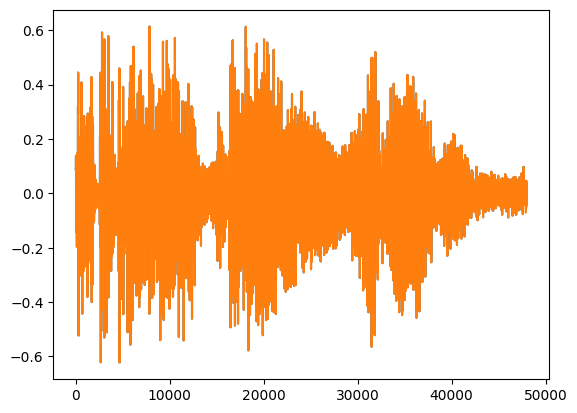

In [ ]:
plt.plot(output[0:rate][256:])
plt.plot(data[0:rate])
print(numpy.allclose(data[0:rate][:-256],output[0:rate][256:]))

In [ ]:
import IPython.display as ipd

In [ ]:

ipd.Audio(output, rate=rate) # load a NumPy array
